In [13]:
import numpy as np
from matplotlib import pyplot as plt

# A Minimal Active Inference Agent

## By André van Schaik

### __[International Centre for Neuromorphic Systems](https://westernsydney.edu.au/icns)__        15/12/2018

This notebook is based on __[a paper](https://arxiv.org/abs/1503.04187)__ with the same title by Simon McGregor, Manuel Baltieri and Christopher L. Buckley. 

I'm using it to investigate Karl Friston's Free Energy and Active Inference concepts. My notebook borrows heavily from one by __[Tomek Korbak](https://github.com/tomekkorbak/active-inference)__, but I didn't want to use anything but vanilla numpy and matplotlib, so I know exactly what is going on at each step.

The notebook simulates the agent described in the paper and illustrated below.

<img src="Agent.png" width="600">

To do so, we first define the functions as given in the paper:

In [71]:
def sensory_dynamics(psi):
    """
    P(s | psi)
    Probability of experiencing sensory state 1 given current position.
    """
    return MAX_SENSE_PROBABILITY * np.exp(-SENSE_DECAY_RATE * 
                np.minimum(np.abs(psi - FOOD_POSITION), np.abs(psi - FOOD_POSITION - ENV_SIZE)))


def model_encoding(b):
    """
    Probability of occupying specific position as encoded in the internal state.
    """
    # Softmax function. The shift by b.max() is for numerical stability
    return np.exp(b - b.max()) / np.sum(np.exp(b - b.max()))


def model_encoding_derivative(b):
    """
    Derivative of the model encoding for free energy gradient calculation
    """
    softmax_b = model_encoding(b)
    # Softmax derivative
    return np.diag(softmax_b) - np.outer(softmax_b, softmax_b)


def generative_density(b, a):
    """
    P(psi', s | b, a)
    Agent's prediction of its new position given its internal state and selected action
    (calculated separately for two sensory states).

    P(psi', s | b, a) = Sum_over_psi(P(psi' | s, b, a, psi) * P(s | b, a, psi) * P(psi | b, a))
                      = Sum_over_psi(P(psi' | a, psi) * P(s | psi) * P(psi | b))
    since psi' only depends on a and psi, s only depends on psi, and psi only depends on b.

    """
    # sensory dynamics for each position: 
    """P(s | psi)"""
    sd = sensory_dynamics(np.arange(ENV_SIZE))
    
    """
    P(psi', s | b, a) = Sum_over_psi(P(psi' | a, psi) * P(s | psi) * P(psi | b))
    Note that the Sum_over_psi is only taken over the two positions psi that can result in getting to psi' given a
    """
    psi_prime_0 = ((1-MOVEMENT_PROBABILITY) * (1 - sd) * model_encoding(b) + 
                 MOVEMENT_PROBABILITY * np.roll((1 - sd) * model_encoding(b), a))

    psi_prime_1 = ((1-MOVEMENT_PROBABILITY) * sd * model_encoding(b) + 
                 MOVEMENT_PROBABILITY * np.roll(sd * model_encoding(b), a))
    
    return [psi_prime_0, psi_prime_1]


def variational_density(b):
    """
    P(psi | b)
    Agent's belief about the external states (i.e. its current position in the 
    world) or intention (i.e. desired position in the world) as encoded in the
    internal state.
    """
    return model_encoding(b)


def KL(a, b):
    """
    Kullback-Leibler divergence between densities a and b.
    """
    return np.sum(a * (np.log(a) - np.log(b)))


def free_energy(b_star, b, s, a):
    """
    KL divergence between variational density and generative density for a fixed
    sensory state s.
    """
    return KL(variational_density(b_star), generative_density(b, a)[s])


def fe_gradient(b_star, b, s, a):
    """
    Partial derivatives of the free energy with respect to belief R1.
    """
    J = model_encoding_derivative(b_star)
    Y = np.log(variational_density(b_star) / generative_density(b, a)[s])
    return np.dot(J,Y)

We also turn the pseudo-code from the paper into Python, and define a function for plotting the results:

In [72]:
def simulate_agent(psi, b, b_star):
    """
    Simulate the agent for EPOCHS steps.
    """
    # start trace at initial position
    psi_trace = [psi]
    
    # show the sensory dynamics given the food distribution at the left of the belief trace
    b_trace = [sensory_dynamics(np.arange(ENV_SIZE))]

    for epoch in range(EPOCHS):

        # Calculate sensory state s \in {0, 1}
        s = int(np.random.random() < sensory_dynamics(psi))

        # Pick action state, a \in {-1, 0, 1}
        # Calculate the free energy given my target (intent) distribution, current state distribution, & sensory input 
        # Do this for all (three) actions and select the action with minimum free energy.
        i = np.argmin((free_energy(b_star, b, s, -1), free_energy(b_star, b, s, 0), free_energy(b_star, b, s, 1)))
        a = (-1, 0, 1)[i]

        # Update actual position by taking action
        psi = (psi + a * (np.random.random() < MOVEMENT_PROBABILITY)) % ENV_SIZE

        # Update my internal state.
        # Start by creating a belief for my new position b_prime, from my belief for my previous position b
        # by mixing according to movement probability given action a:
#         b_prime = MOVEMENT_PROBABILITY * np.roll(b, a) + (1 - MOVEMENT_PROBABILITY) * b
        # Note, this is not essential, as the minimisation below will update b_prime,
        # but it does provide a good starting point for gradient descent
        b_prime = np.zeros(ENV_SIZE)

        # Now minimise free energy
        for step in range(N_STEPS):
            b_prime -= LEARNING_RATE * fe_gradient(b_prime, b, s, a)

        # Save position and internal state for plotting
        b = b_prime.copy()
        psi_trace.append(psi)
        b_trace.append(model_encoding(b))

    # Show the target position as probability distribution at the right of the belief trace
    b_trace.append(model_encoding(b_star)) 
    return (b_trace, psi_trace)


def plot_traces(b_trace, psi_trace):
    """
    Helper function for plotting agent's internal state and position.
    """
    fig = plt.figure(figsize=(15, 4))
    ax = fig.gca()
    im = ax.imshow(np.transpose(b_trace),
              interpolation="nearest", 
              aspect = "auto", 
              vmin = 0, vmax = 1, 
              cmap = "viridis")
    ax.scatter(list(range(EPOCHS+1)), psi_trace, color = "red")
    ax.invert_yaxis()
    ax.set_xlim([0,EPOCHS+1])
    fig.colorbar(im)
    return fig

Now we are ready to run a simulation based on the parameters used in the paper. The numbers above the figure below indicate the probability for a HIGH sensor output at each of the 16 positions. Different from the paper, we give the agent a strong intention (defined by b_star) to be in position 3. 

[0.45850202 0.5        0.54525387 0.59460356 0.64841978 0.70710678
 0.77110541 0.84089642 0.91700404 0.84089642 0.77110541 0.70710678
 0.64841978 0.59460356 0.54525387 0.5       ]


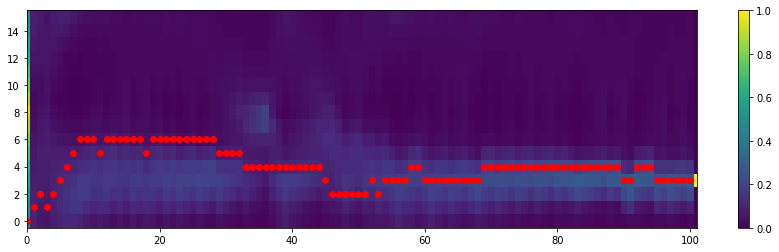

In [73]:
ENV_SIZE = 16
INITIAL_POSITION = 0
FOOD_POSITION = 8
MOVEMENT_PROBABILITY = 0.75

# Sensory dynamics parameters
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega

# Position (external state), Psi \in (0,15)
psi = INITIAL_POSITION

# Internal state, R \in R^16
b = np.zeros(ENV_SIZE)

# Internal state (as intention), Ri \in R^16
TARGET_POSITION = 3
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10 # strong preference for a single target position

# Simulation parameters
EPOCHS = 100                 # Number of epochs (simulation steps).
N_STEPS = 100                # Number of gradient descent steps made to update beliefs in each epoch.
LEARNING_RATE = 0.7          # Stochastic gradient descent learning rate

# Run simulation
(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

# Plot output
fig = plot_traces(b_trace, psi_trace)

# Print sensory spike probability as a function of position
print(sensory_dynamics(np.arange(ENV_SIZE)))

In the figure above, the first column shows the starting position and the sensory probabilities. The final column shows the Intention State b_star, and the columns in between show how the agent's internal state evolves after each action. The colourbar indicates the probability for each position according to the agent's internal state. The red dots indicate the agent's true position.

Because the difference in HIGH sensory output is less than 5% between positions 3, 4, and 5, it is difficult for the agent to be certain where it is exactly, but it does a decent job staying around position 3.

We can simplify the situation for the agent, by having (near) deterministic movement and sensor response at the position with maximum food (position 8). In the example below we also drop the probability of sensory activation rapidly as a function of distance from position 8, and set the target position to 8.

[3.35127165e-04 9.10970084e-04 2.47627342e-03 6.73120905e-03
 1.82973232e-02 4.97372813e-02 1.35199948e-01 3.67511562e-01
 9.99000000e-01 3.67511562e-01 1.35199948e-01 4.97372813e-02
 1.82973232e-02 6.73120905e-03 2.47627342e-03 9.10970084e-04]


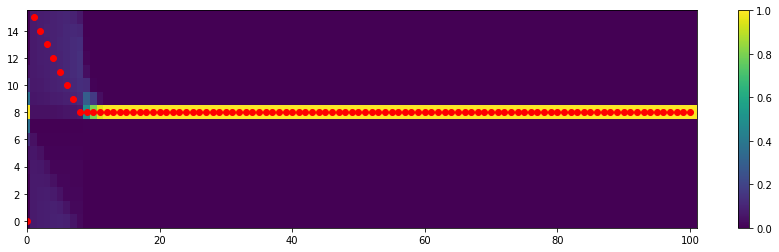

In [74]:
MOVEMENT_PROBABILITY = 0.999
MAX_SENSE_PROBABILITY = 0.999
SENSE_DECAY_RATE = 1
TARGET_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

print(sensory_dynamics(np.arange(ENV_SIZE)))

Clearly, the task is very simple here. Find the position where the sensor output is always HIGH and stay there.

It is slightly trickier to stay in another position, where the sensor doesn't always fire, although position 7 is still easy.

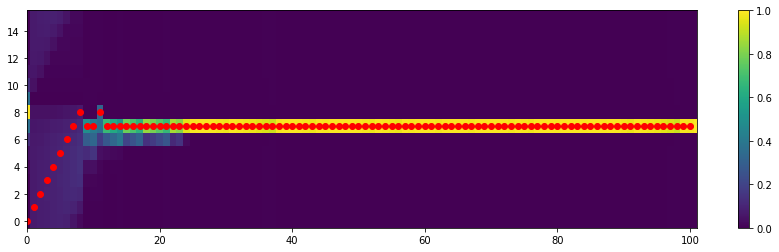

In [75]:
TARGET_POSITION = 7

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

With position 5 as a target, it becomes difficult as the sensor is HIGH less than 5% of the time.

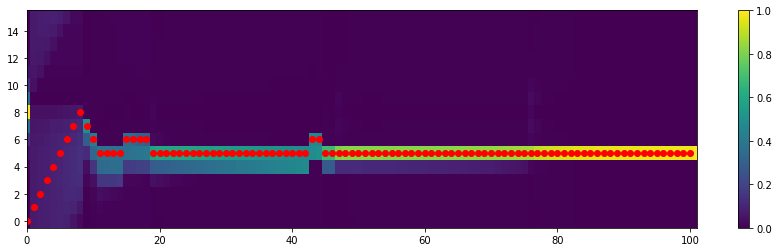

In [76]:
TARGET_POSITION = 5

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

And at position 0, and nearby positions, the sensor almost never fires, leaving the agent with little information about its position.

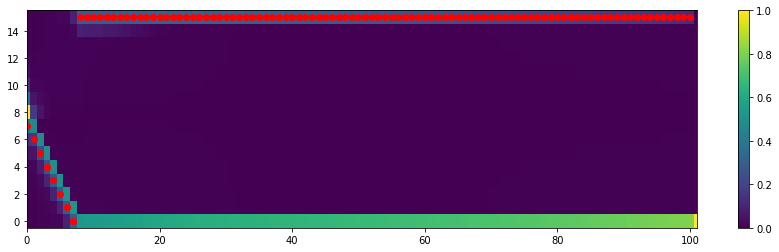

In [77]:
TARGET_POSITION = 0

psi = INITIAL_POSITION+7
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

With the original distribution of sensor probabilities, the agent receives more HIGH readings around position 0.

[0.45850202 0.5        0.54525387 0.59460356 0.64841978 0.70710678
 0.77110541 0.84089642 0.91700404 0.84089642 0.77110541 0.70710678
 0.64841978 0.59460356 0.54525387 0.5       ]


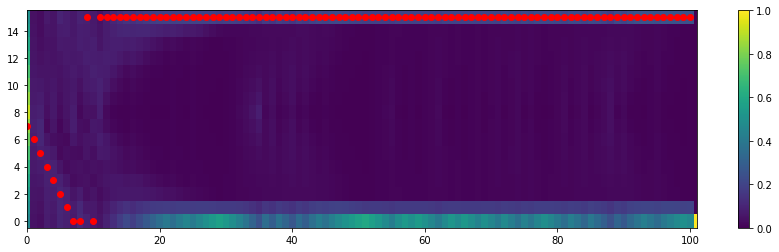

In [78]:
# Sensory dynamics parameters
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega

TARGET_POSITION = 0

psi = INITIAL_POSITION+7
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

print(sensory_dynamics(np.arange(ENV_SIZE)))

And it is still an easy task when the target position is position 8 with maximum food.

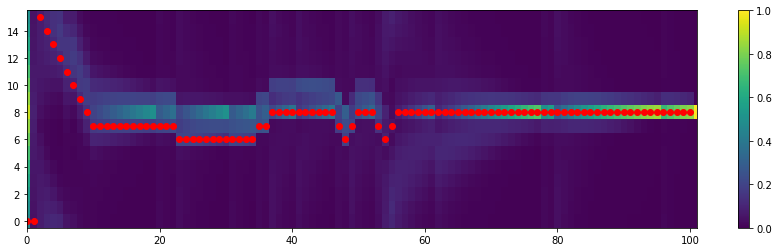

In [79]:
TARGET_POSITION = 8

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

Lowering the movement probability makes it more likely that agent's MAP belief in its position doesn't correspond to its true position.

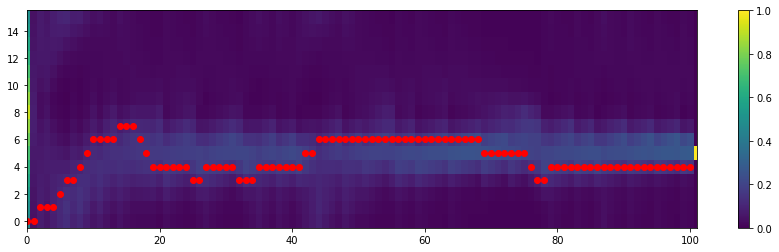

In [80]:
MOVEMENT_PROBABILITY = 0.5
TARGET_POSITION = 5

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

If we lower the level of intent for the target position, so the target density is less peaked, the agent wanders around more.

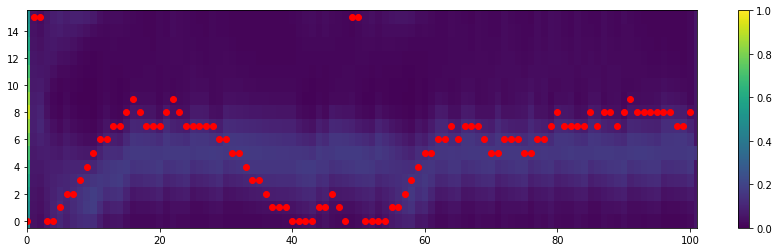

In [81]:
MOVEMENT_PROBABILITY = 0.5
TARGET_POSITION = 5

psi = INITIAL_POSITION
b = np.zeros(ENV_SIZE)
b_star = np.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 1

(b_trace, psi_trace) = simulate_agent(psi, b, b_star)

fig = plot_traces(b_trace, psi_trace)

In conclusion, the agent behaviour is as follows:

* Get sensor output `s` at current position;
* Pick an action `a` that minimises the KL divergence between the target (Intent) density `b_star` and the generative density. The latter generates a joint probability for the next position `psi_prime` and current sensor observation `s`, depending on the agent's belief about its current position `b` and the actions `a` that are being considered;
* Update position `psi` by taking action `a` with probability `MOVEMENT_PROBABILITY`;
* Minimise the KL divergence between the internal state `b_prime` for the next position and the generative density for the chosen action `a`;
* Update internal state `b` with `b_prime`;
* Repeat.
